# Multi Layer Perceptron

## Activation Functions

They decide whether a neuron should be active or not by calculating the weighted sum and adding bias to it, They are differentiable  operators for transforming inputs signals into outputs, most of them adds non-linearity 

In [4]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### ReLU Function

$ReLU(𝑥) = max(𝑥,0).$

- It only returns positive elements and discards all negative elements by setting their values into 0
- When the input is negative, the derivative of the ReLU function is 0, when the input is positive, the derivative  is 1, but the function is not differentiable if the input is precisely equal to 0, in this case we default to the left-hand side derivative and say it is 0
- The reason we use ReLU is that its derivatives are well behaves wither they vanish or they just let the argument go through. making optimization better behaved, helping the problem of vanishing gradients
- There is also many variants like Parameterized ReLU (pReLU)  that adds a linear term to ReLU so some information still gets through when when the arguments are negative
    - $pReLU(𝑥) = max(0,𝑥) + 𝛼min(0,𝑥).$

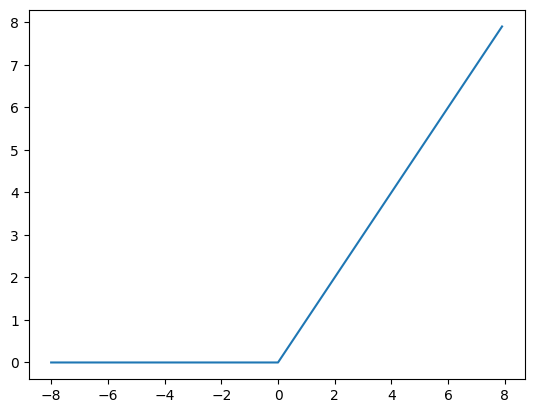

In [5]:
x = torch.arange(-8., 8., .1, requires_grad=True)
y = torch.relu(x)
plt.plot(x.detach(),y.detach())

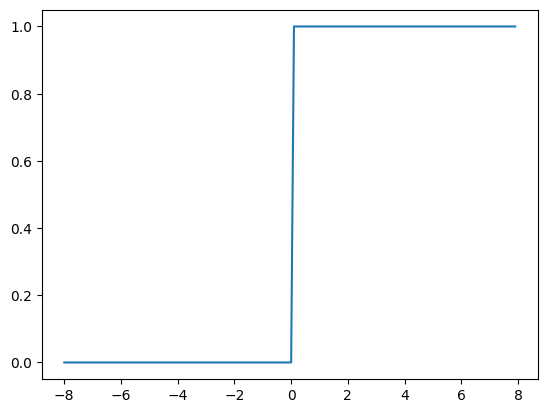

In [6]:
#Let's plot the derivative of the ReLU
y.backward(torch.ones_like(x), retain_graph=True)
plt.plot(x.detach(), x.grad)

### Sigmoid Function

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

- The function transforms those inputs whose values lie in the domain ℝ, to outputs that lie on the interval (0, 1), that’s why it is often called a squashing function, it squashes any input in the range of (-inf, inf) into (0, 1) range.
- In the earliest neural network research, scientists was inspired by the bio neurons that either fire or don’t fire. So they focused on a thresholding activation that takes value 0 when the input is below some threshold and value 1 when it exceeds that threshold.
- We use the Sigmoid when we want to interpret the outputs as probabilities for binary classification problems
- You can think of sigmoid as a special case of Softmax, However it is been replaced by the simpler and more easily trainable ReLU for most use in hidden layers
- Sigmoid have challenges for optimization, since its gradient vanishes for large positive and negative arguments

$$
\frac{d}{dx} \sigma(x) = \frac{e^{-x}}{(1 + e^{-x})^2}
$$

This can also be written in terms of the sigmoid function itself:

$$
\frac{d}{dx} \sigma(x) = \sigma(x)(1 - \sigma(x))
$$
- The derivative of the sigmoid, when the input is 0 reaches a maximum , as the input diverges from 0 i either direction the derivative approaches 0

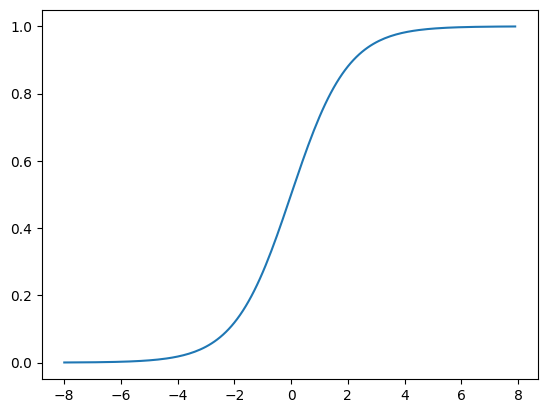

In [7]:
# Sigmoid
y = torch.sigmoid(x)
plt.plot(x.detach(), y.detach())

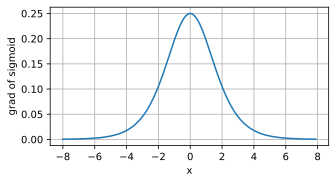

In [8]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### Tanh Function

$$
tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

- Just like the sigmoid function the tanh also squashes its inputs transforming them into elements on the interval between -1 and 1
- when plotting the tanh function, as input nears 0, the tanh approaches a linear transformation
- The difference between it and sigmoid even they look similar when plotted, is that tanh exhibits point symmetry about the origin of the coordinates
- The derivative of the tanh, as input is near 0 the derivative approaches a maximum of 1, and as sigmoid when the input moves either direction the derivative approaches 0

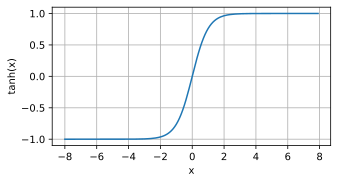

In [9]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

## Multi Layer Perceptron

- It’s recommended to choose layer widths to be divisible by larger powers of 2, This is computationally efficient due to the way memory is allocated in hardware.
- To automatically register a class attribute as a parameter to be tracked by `autograd` we use `nn.Parameter`.

### From Scratch Implementation

In [10]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hidden, lr, sigma=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs,num_hidden)* sigma)
        self.B1 = nn.Parameter(torch.randn(num_hidden))
        self.W2 = nn.Parameter(torch.randn(num_hidden,num_outputs)* sigma)
        self.B2 = nn.Parameter(torch.randn(num_outputs))
    def forward(self, x):
        x = x.reshape((-1, self.num_inputs))
        h = relu(torch.matmul(x, self.W1)+ self.B1)
        return torch.matmul(h, self.W2) + self.B2
def relu(x):
    a = torch.zeros_like(x)
    return torch.max(x, a)


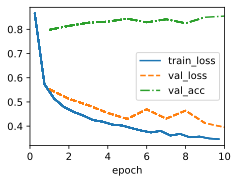

In [11]:
model = MLPScratch(num_inputs=28*28,num_outputs=10, num_hidden=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### Concise Implementation

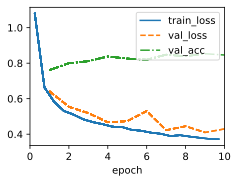

In [12]:
#MLP with higher 
from torch import nn
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
# We don't need to define the forward method, cause the sequential class
# abstracts the forward process
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

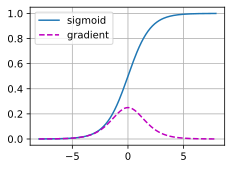

In [13]:
x = torch.arange(-8., 8., 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))
d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'])

## Dropout

- What do we expect from a predictive model? we want it to Generalize on unseen data.
- Classical Generalization Theory suggests that to close the gap between train and test performance, we should aim for a simple model, or with smoothness i.e., that the function shouldn’t be sensitive to small changes to its inputs For instance when we classify images we would expect that adding some random noise to the pixels should be mostly harmless
- Dropout involves injecting noise while computing each internal layer during forward propagation, this happens by dropping out some neurons during training (zeroing out some fraction of the nodes in each layer before calculating the subsequent one)
- The authors argued that neural network overfitting is characterized by a state in which each layer relies on a specific pattern of activations in the previous layer (co-adaptation).
- The challenge is how to inject this noise. One idea is to inject in an unbiased manner so the expected value of each layer equals the value it would have taken absent noise, In Bishop’s work he has added Gaussian Noise to the inputs to a linear model, At each iteration he added noise sampled from a distribution with mean zero to the input x
- In standard dropout regularization, we zero out some nodes in each layer then debiases each layer by normalizing it by a fraction of nodes that were retained (not dropped out), In other word, with dropout probability p each intermediate activation h is replaced by a random variable ĥ as follows
    
    ![image.png](Images\\image 3.png)
    

$$
h'=\begin{cases}0&\text{with probability} {p}\\\frac{h}{1-p}&\text{otherwise}\end{cases}
$$


In [14]:
def dropout_layer(X, dropout):
    assert 0<=dropout<=1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0-dropout)

In [15]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  0.,  0.,  0.,  0., 12., 14.],
        [ 0.,  0., 20., 22., 24., 26.,  0.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [16]:
class DropMLPScratch(d2l.Classifier):
    def __init__(self, num_out, num_hidden1,num_hidden2, drop1, drop2, lr ):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hidden1)
        self.lin2 = nn.LazyLinear(num_hidden2)
        self.lin3 = nn.LazyLinear(num_out)
        self.relu = nn.ReLU()
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.drop1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.drop2)
        return self.lin3(H2)

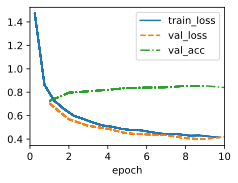

In [17]:
hparams = {'num_out':10, 'num_hidden1':256, 'num_hidden2':256,
'drop1':0.5, 'drop2':0.5, 'lr':0.1}
model = DropMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [18]:
class DropMLP(d2l.Classifier):
    def __init__(self, num_out, num_hidden1, num_hidden2, drop1, drop2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hidden1),
            nn.ReLU(),
            nn.Dropout(drop1),
            nn.LazyLinear(num_hidden2),
            nn.ReLU(),
            nn.Dropout(drop2),
            nn.LazyLinear(num_out)
        )

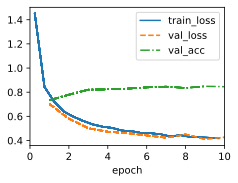

In [19]:
model = DropMLP(**hparams)
trainer.fit(model, data)